# Problem

    For this capstone project, I have decided to tackle the task of face mask detection. This belongs to the field of object detection. Object detection consists on two things basically. The first one, on detecting whether an specific object is present on an image, for instance: a dog, a person, a chair, a tumor, etc. The second one,  consists on being able to tell the closest bounding box coordinates that contain an specific object. It is important to mention that many instances of the same object can be present on an image. For my problem, I would like to be able to detect whether a person is wearing a face mask or not.

# Solution approach

    My approach to the mask detection problem will be a supervised deep learning algorithm. The current state-of-the art network architecture for object detection is called YOLO (YOU-ONLY-LOOK-ONCE). This algorithm is designed for performing object detection in real time. We will talk about the details of this network architecture, but for now, as part of the data exploration step, we need to describe the inputs of our algorithm.

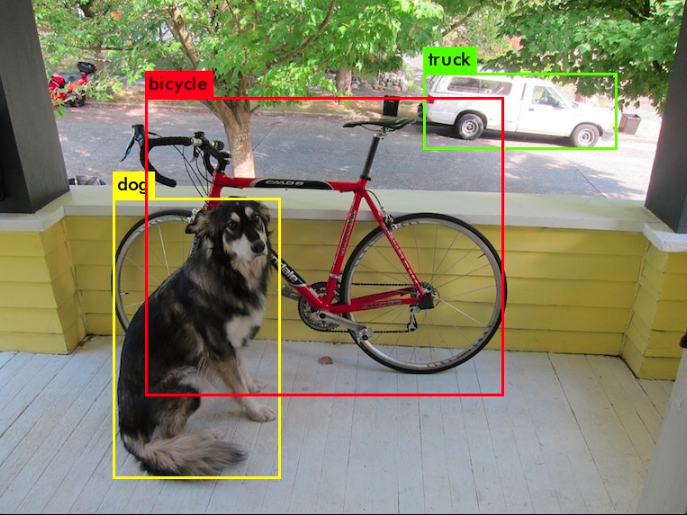

                                    Object detection example from the YOLO paper

# Yolo input

    If we want to train an object detection algorithm, we need 2 things: 

    - First thing's first: We need MANY images depicting people with and without masks. These images should have variations in quality, size, and in the case of images from people wearing masks, it is important to make to include images from masks with different colors and variations.
    
    -Second: We need annotations indicating the coordinates of the bounding boxes containing object instances.

# Datasets for mask detection

In [1]:
#I gathered all images inside this directory
path_images = './data/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/'

**- Kaggle dataset: https://www.kaggle.com/andrewmvd/face-mask-detection**

    Description: Contains annotations and images of people wearing masks. The particularity of this dataset is that most images contain crowds of people. A greater amount of people wearing masks is depicted compared to people with their faces uncovered. This problem is called class imbalance, and if not treated properly it can cause our network to only learn to detect the majority class.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig=plt.figure(figsize=(15, 8))
columns = 3
rows = 2

images = ['maksssksksss51','maksssksksss508','maksssksksss4','maksssksksss52','maksssksksss41','maksssksksss79']
for i in range(1, columns*rows +1):
    img=mpimg.imread(path_images + images[i-1] + '.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

<Figure size 1500x800 with 6 Axes>

**- RMFD dataset: https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset**

    Description: Looking though the internet I came up with a dataset of images for mask detection. We can notice that most images contain clear high definition images with depicting mostly one person. In case we wanted to test our images on a real environment where images are blurry or low quality, we need to make sure our validation and test sets come from the same distribution. But this high quality images can still serve for our training set.

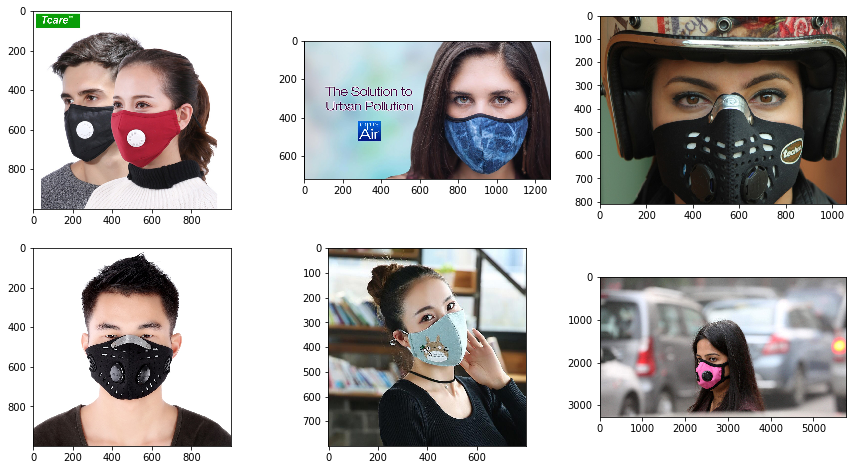

In [3]:
fig=plt.figure(figsize=(15, 8))
columns = 3
rows = 2

images = ['2020_02_198','2020_02_199','2020_02_200','2020_02_201','2020_02_202','2020_02_203']
for i in range(1, columns*rows +1):
    img=mpimg.imread(path_images + images[i-1] + '.jpg')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

   **- Mask dataset collected using web scraping (Explained on the data preparation notebook)**

    This dataset mostly contains good quality images of people walking down the street, as well as images portraying only one person.

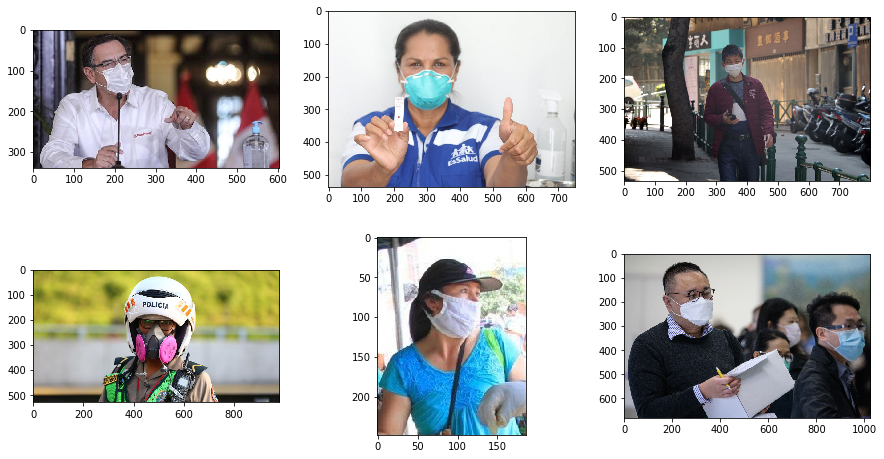

In [4]:
fig=plt.figure(figsize=(15, 8))
columns = 3
rows = 2

images = ['2020_419','2020_193','2020_195','2020_203','2020_217','2020_230']
for i in range(1, columns*rows +1):
    img=mpimg.imread(path_images + images[i-1] + '.jpg')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

**- PASCAL VOC dataset:** http://host.robots.ox.ac.uk/pascal/VOC/

    For our images containing instances of people not wearing masks, we decided to use a subset of a well-known dataset called PASCAL VOC. This dataset contains annotated images from many classes including "person". I chose a subset of images from this class. The problem I found was that annotations included full body annotations, and I only cared about bounding boxes with the face. Some images do contain face annotations, but they were not enough, so I decided to manually annotate them.

    My manual annotations for the PASCAL VOC dataset can be accesed on my Github: link

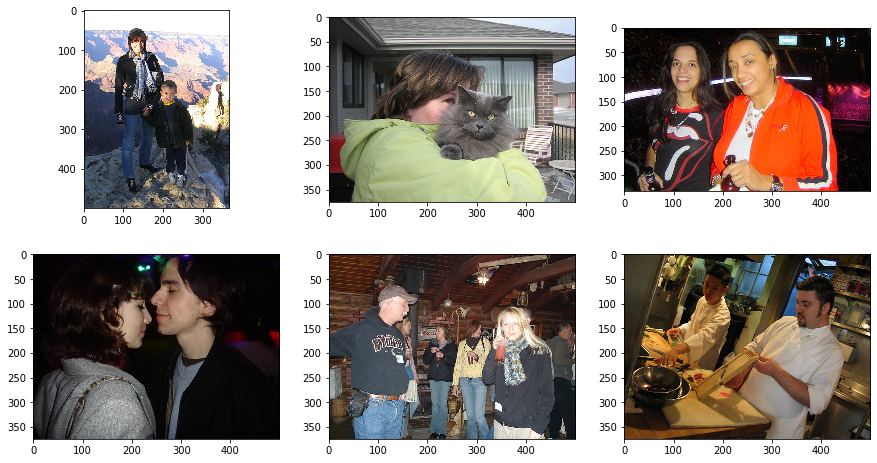

In [5]:
fig=plt.figure(figsize=(15, 8))
columns = 3
rows = 2

images = ['2008_000844','2008_000847','2008_000851','2008_000985','2008_001063','2008_001115']
for i in range(1, columns*rows +1):
    img=mpimg.imread(path_images + images[i-1] + '.jpg')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()

# Generating Annotations for Images

There exists several tools for labeling images for our custom datasets. The tool we are using is called **labelImg** (Download link: https://github.com/tzutalin/labelImg ). Cool thing about this program is that it generates XML Annotation files with an standard structure used on the PASCAL VOC as well.

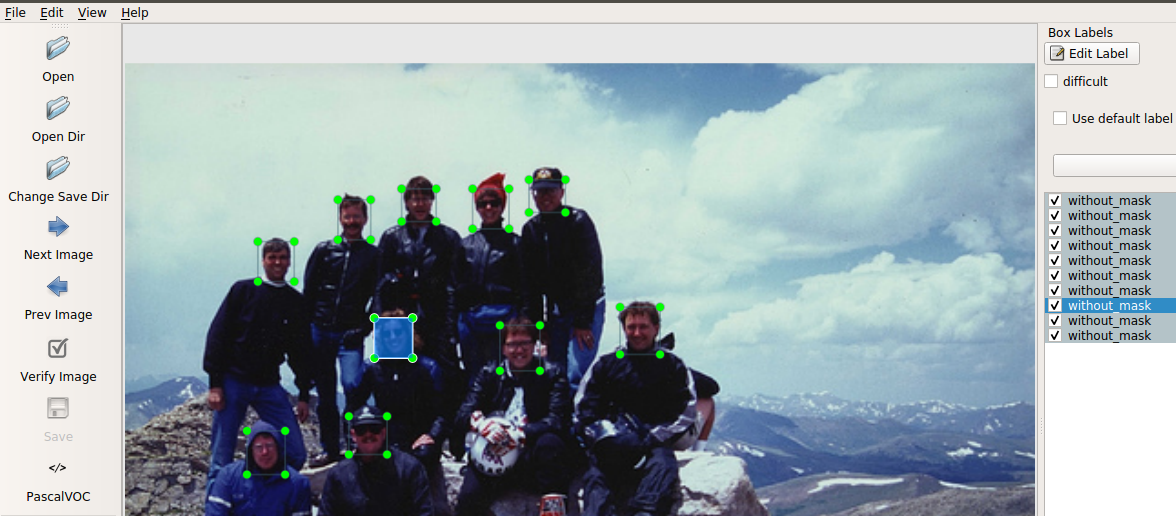

**Example Annotation Structure**

    All annotations have metadata about the image, and object classes as well as bounding box coordinates xmin, ymin, xmax and ymax are specified inside the <object> tag.


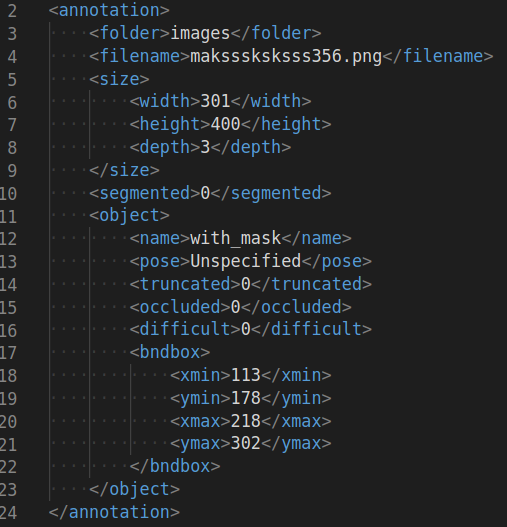

Annotated images from all datasets.

# Measuring class imbalance

It is somehow difficult to tell how imbalanced our dataset is only from the number of images, because inside each image there are one or more instances from all classes, and in some of them, more than two classes are present. For this matter, we are traversing all xml files, and counting the number of objects belonging to our different classes.



First of all, we are defining global variables for counting the number of occurrences for each group:

In [6]:
with_mask = 0 
without_mask = 0
mask_weared_incorrect = 0

In [7]:
def parse_xml(xml):
    
    global with_mask 
    global without_mask
    global mask_weared_incorrect
    
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != "object":
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            
            if child_result[child.tag]['name']=='with_mask':
                with_mask = with_mask + 1
            elif child_result[child.tag]['name']=='without_mask': 
                without_mask = without_mask + 1
            elif child_result[child.tag]['name']=='mask_weared_incorrect': 
                mask_weared_incorrect = mask_weared_incorrect + 1
                
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}

In [8]:
annotations_path = './data/voc2012_raw/VOCdevkit/VOC2012/Annotations/' #Path for image annotations
txt_path = './data/voc2012_raw/VOCdevkit/VOC2012/ImageSets/Main/' #Path for training, validation and test txt files 

Traversing train.txt file in order to extract all training sample names and then store them on train_samples list:

In [9]:
train = open(txt_path + 'train.txt')
train_samples = []
    
Lines = train.readlines()
for line in Lines:
    line = line.split()
    train_samples.append(line[0])

print("Total number of training samples: ",len(train_samples))

Total number of training samples:  2101


Reading every xml filename contained on train_samples list using parse_xml function:

In [10]:
import os
import lxml.etree

for filename in train_samples:
    annotation_xml = annotations_path + filename + ".xml"
    annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
    parse_xml(annotation_xml)

In [11]:
print("Number of samples with class 'with_mask': ",with_mask)
print("Number of samples with class 'without_mask': ",without_mask)
print("Number of samples with class 'mask_weared_incorrect': ",mask_weared_incorrect)

Number of samples with class 'with_mask':  3543
Number of samples with class 'without_mask':  1996
Number of samples with class 'mask_weared_incorrect':  98


Now we plot class imbalance for a better visualization:

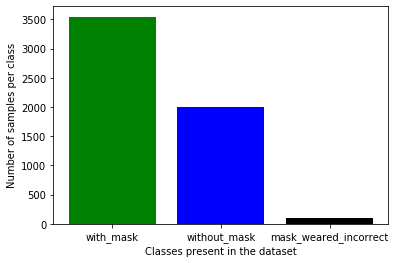

In [12]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# Make a fake dataset
height = [with_mask, without_mask, mask_weared_incorrect]
bars = ('with_mask', 'without_mask', 'mask_weared_incorrect')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height, color=['green', 'blue', 'black'])
plt.xticks(y_pos, bars)

plt.xlabel("Classes present in the dataset")
plt.ylabel("Number of samples per class")

plt.show()

In [13]:
total = with_mask+without_mask+mask_weared_incorrect
print("Total number of object instances: ",total)

Total number of object instances:  5637
